<a href="https://colab.research.google.com/github/Nkybahibey/dissertation_project/blob/main/229_Gaussian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installing all the libraries we'll me using for the project
!pip -q install torchinfo opencv-python mlxtend torchmetrics opendatasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 24.0 MB/s eta 0:00:00


In [ ]:
# Importing all of the modules we need
import torch # Importing pytorch
from torch import nn # Importing nn module from pytorch which we would use to build our model
from torch.utils.data import Dataset, DataLoader # Dataset and dataloader would be used to creating a dataset and batching it respectively
import matplotlib.pyplot as plt # Matplotlib for visualizing
import torchvision # Torchvision is a module from pytorch that helps us work with vision data
from torchvision import transforms # Transforms is a module from pytorch that helps us augment our images
from pathlib import Path # Pathlibs is used to create system paths among other functions
import random # As the name implies, its random
from PIL import Image # Image is a module from pillow that helps us process images
import pandas as pd # I need pandas for processing csv files
from torchinfo import summary # This is used to print useful information about our model
from torchvision.datasets import ImageFolder # We would not be using imagefolder in this case as out files would not come from a directory but rather a csv file
import cv2 # This is used for image processing as well
import numpy as np # I would be using numpy to process images in our custom transformation
import opendatasets as od # This would be used to download our dataset from kaggle
from torchmetrics import ConfusionMatrix, Accuracy, Precision, Recall, F1Score # This is to calculate the various metrics on the performance of our model
from google.colab import files, drive # This is not needed

In [ ]:
od.download('https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-224x224-2019-data') # Downloading the dataset to our colab instance, you would need to enter your kaggle username and password

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Nkybahibey
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-224x224-2019-data


100%|██████████| 238M/238M [00:14<00:00, 17.5MB/s]


In [ ]:
image_path = '/content/diabetic-retinopathy-224x224-2019-data/colored_images' # This is the path where our images are located after they are downloaded

image_list = list(Path(image_path).glob('*/*.png')) # Creates a list of all the images we have in the folder

df = pd.DataFrame({'images': [f'{i.parent.name}/{i.name[:-4]}' for i in image_list], 'labels': [i.parent.name for i in image_list]}, columns=['images', 'labels']) # Creates a dataframe with all the images in the folder along with their respective classes
df['labels'] = df['labels'].map({'No_DR': 0, 'Mild': 1, 'Moderate': 2, 'Severe':3, 'Proliferate_DR':4},) # Maps the classes to numbers from 0-4
df.head() # This is what our dataframe now looks like

,images,labels
0,Moderate/44855f666225,2
1,Moderate/5152bf091152,2
2,Moderate/b99c825b93c5,2
3,Moderate/475c7ded0f7a,2
4,Moderate/a3475dc3ac80,2


In [ ]:
df['labels'].value_counts() # Counting all of the images we have for each class

,count
labels,
0,1805
2,999
1,370
4,295
3,193


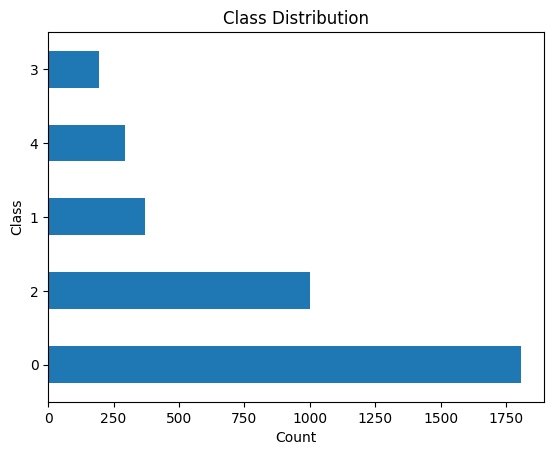

In [ ]:
# Using matplot lib to make visual representation of the imformation above
df['labels'].value_counts().plot(kind='barh')
plt.title('Class Distribution')
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()

In [ ]:
# EqHist is a custom class that performs histogram equalization on images it is fed and returns the transformed image
class EqHist(object):
    ''' Converts images to grayscale and equalie the hist with clache '''
    def __init__(self, beta=-4, sigmaX=10):
        self.beta = beta
        self.sigmaX = sigmaX

    def __call__(self, sample):
        img = np.asarray(sample).astype(np.uint8)
        img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0,0), self.sigmaX), self.beta, 125)
        img = Image.fromarray(img)
        return img

# train_transforms is the augmentation instance we would use for our training data
train_transforms = transforms.Compose([
    EqHist(), # Performs histogram equalization
    transforms.Resize(size=[224,224]), # Resizes the image to 224x224
    transforms.RandomHorizontalFlip(p=0.5), # 50% chance to flip the images horizontally
    transforms.ToTensor(), # Converts the images to numbers within 0-1
])
test_transforms = transforms.Compose([
    EqHist(),
    transforms.Resize(size=[224,224]),
    transforms.ToTensor(),
])

In [ ]:
temp = image_path + '/{image_name}.png' # The format for reading our images

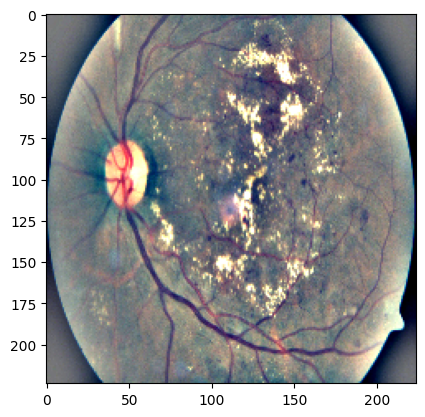

In [ ]:
# Testing our train_transforms instance to see it actually works
trans_img = train_transforms(Image.open(temp.format(image_name=df.iloc[0]['images'])))
plt.imshow(trans_img.permute(1,2,0))

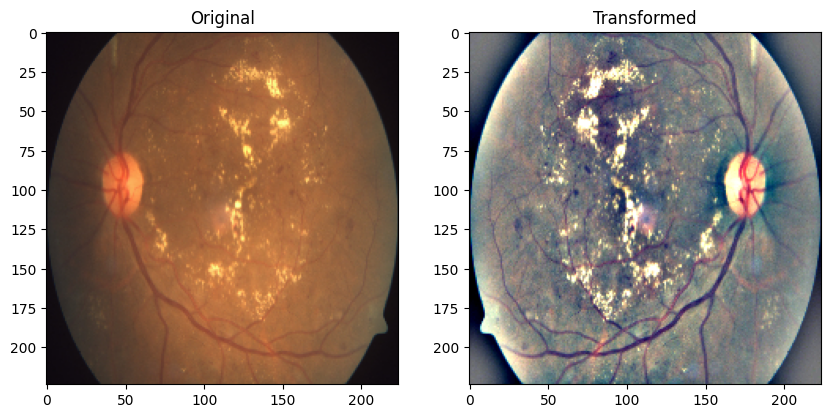

In [ ]:
# Side by side comparison between the original image and the augmented image
trans_img = train_transforms(Image.open(temp.format(image_name=df.iloc[0]['images'])))
fig, ax = plt.subplots(figsize=(10,10), nrows=1, ncols=2)
ax[0].imshow(Image.open(temp.format(image_name=df.iloc[0]['images'])))
ax[0].set_title('Original')
ax[1].imshow(trans_img.permute(1,2,0))
ax[1].set_title('Transformed')
plt.show()

In [ ]:
minor_df = df # initializing a new dataframe from our old dataframe

In [ ]:
sorted(list(df['labels'].unique()))  # listing the labels in our dataset and sorting them

[0, 1, 2, 3, 4]

In [ ]:
minor_df['labels'].value_counts() # Checking the count of number of images present in each class

,count
labels,
0,1805
2,999
1,370
4,295
3,193


In [ ]:
# minor_df = minor_df.drop(minor_df.query('labels == 0')[1000:].index, axis=0)
# minor_df['labels'].value_counts()

In [ ]:
# minor_df = minor_df.drop(minor_df.query('labels == 1')[200:].index, axis=0)
# minor_df['labels'].value_counts()

In [ ]:
# minor_df = minor_df.drop(minor_df.query('labels == 2')[500:].index, axis=0)
# minor_df['labels'].value_counts()

In [ ]:
# minor_df = minor_df.drop(minor_df.query('labels == 3')[50:].index, axis=0)
# minor_df['labels'].value_counts()

In [ ]:
# minor_df = minor_df.drop(minor_df.query('labels == 4')[50:].index, axis=0)
# minor_df['labels'].value_counts()

In [ ]:
# Creating a train test split, test_df is our test data which is 20% of the entire dataset
test_df = minor_df.sample(frac=0.2).sort_values('labels').reset_index(drop=True)
test_df

,images,labels
0,No_DR/4faf4063db8c,0
1,No_DR/c755a0c4edcc,0
2,No_DR/f5c953bee7cd,0
3,No_DR/f4ea2a2cfbb9,0
4,No_DR/6fbaaf8eb67a,0
...,...,...
727,Proliferate_DR/65e120143825,4
728,Proliferate_DR/21abd36095a1,4
729,Proliferate_DR/753b14c27c83,4
730,Proliferate_DR/b87f9c59748b,4


In [ ]:
# Getting our train data from the original dataset and shuffling it to make it random
train_df = minor_df[~minor_df.images.isin(test_df.images)].sample(frac=1).reset_index(drop=True)
train_df

,images,labels
0,No_DR/2f8d14a7d390,0
1,Moderate/39b5b05d6cd9,2
2,Proliferate_DR/785777558f05,4
3,Moderate/09f6ab477654,2
4,Proliferate_DR/262ad704319c,4
...,...,...
2925,Proliferate_DR/b77b8a1f09f1,4
2926,Moderate/8e63fc4ab532,2
2927,Mild/a19ecd0a706e,1
2928,No_DR/f35d80bb1a22,0


In [ ]:
# Using torch dataset to define how how data is presented. Check torch dataset for documentation
class ImageDataset(Dataset):
    def __init__(self, df, image_path=image_path, transform=train_transforms):
        super().__init__()
        self.temp = image_path + '/{image_name}.jpeg'
        self.df = df
        self.transform = transform
        self.classes = sorted(list(df['labels'].unique()))
        self.targets = torch.tensor(list(self.df['labels']))

    def __getitem__(self, idx):
        image_name = self.df.iloc[idx]["images"]
        image_label = self.df.iloc[idx]["labels"]
        return self.do_transform(image_name=image_name), image_label # returns our transforms image and respective label

    def __len__(self):
        return len(self.df)

    def do_transform(self, image_name): # performs our transform on the image it's passed
        img = self.transform(Image.open(temp.format(image_name=image_name)))
        return img

train_data = ImageDataset(df=train_df, image_path=image_path, transform=train_transforms) # Initialized dataset for our training data
test_data = ImageDataset(df=test_df, image_path=image_path, transform=train_transforms) # Initialized dataset for our testing data
len(train_data), len(test_data)

(2930, 732)

Text(0.5, 1.0, '0')

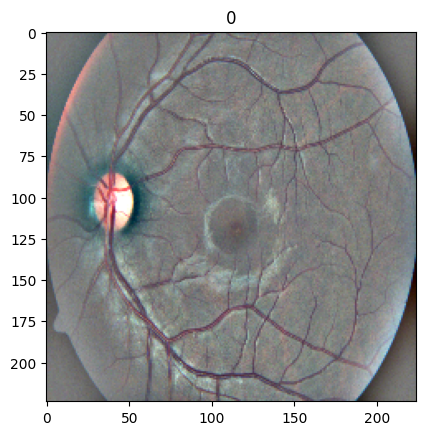

In [ ]:
# Visualizing that our dataset works properly
img, label = test_data[99]
plt.imshow(img.permute(1,2,0), cmap='gray')
plt.title(label)

In [ ]:
# Initializing a dataloader to batch our images with a batch size of 32. Check torch dataloader for documentation
train_dataloader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=32, shuffle=False)
len(train_dataloader), len(test_dataloader)

(92, 23)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Declaring which device we want to use for training. If a gpu is available, use GPU else, CPU

# First, we are loading a pretrained model from torchvision.models, using a for loop, we freeze all of the initial weights because we don't want to train the entire model.
# Second, we swap out the last layer in the network with a new one that fits our use case. (Originally returns 1000 predictions, after being swapped it now returns 5 which is the lenth of class we have in our dataset)

# To train resnet model, uncomment this and comment out densenet
## RESNET
# model = torchvision.models.resnet101(weights='IMAGENET1K_V2')
# for params in model.parameters():
#     params.requires_grad = False

# cin = model.fc.in_features
# model.fc = nn.Sequential(
#     nn.Linear(in_features=cin, out_features=len(train_data.classes))
# )

# To train densenet model, uncomment this and comment out resnet
## DENSENET
model = torchvision.models.densenet121(weights='IMAGENET1K_V1')
for params in model.parameters():
    params.requires_grad = False

cin = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(in_features=cin, out_features=len(train_data.classes))
)

model.to(device)

print(model)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 155MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
summary(model, input_size=[1,3,224,224]) # Visualizing our model with dummy test

Layer (type:depth-idx)                   Output Shape              Param #
DenseNet                                 [1, 5]                    --
├─Sequential: 1-1                        [1, 1024, 7, 7]           --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         (9,408)
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         (128)
│    └─ReLU: 2-3                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 64, 56, 56]           --
│    └─_DenseBlock: 2-5                  [1, 256, 56, 56]          --
│    │    └─_DenseLayer: 3-1             [1, 32, 56, 56]           (45,440)
│    │    └─_DenseLayer: 3-2             [1, 32, 56, 56]           (49,600)
│    │    └─_DenseLayer: 3-3             [1, 32, 56, 56]           (53,760)
│    │    └─_DenseLayer: 3-4             [1, 32, 56, 56]           (57,920)
│    │    └─_DenseLayer: 3-5             [1, 32, 56, 56]           (62,080)
│    │    └─_DenseLayer: 3-6             [1, 32

In [ ]:
criteron = nn.CrossEntropyLoss() # initializing the loss function for our model
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3) # initializing an optimizer for our model (used adam optimizer with a learning rate of 0.003)

In [ ]:
torch.manual_seed(42) # seed for reproducibility
torch.cuda.manual_seed(42) # seed for reproducibility
epochs = 20 # number of epochs to train

# Function to carry out training given some arguments
def train_model(model: torch.nn.Module, epochs: int, train_dataloader: torch.utils.data.DataLoader, test_dataloader: torch.utils.data.DataLoader, criteron: torch.nn.Module, optimizer: torch.optim.Optimizer):
    model_logs = pd.DataFrame(columns=['epoch', 'trainloss', 'testloss', 'trainaccuracy', 'testaccuracy']) # initialize an empty dataframe to keep model logs
    for epoch in range(epochs):
        print('starting...')
        train_loss, test_loss, train_acc, test_acc = 0, 0, 0, 0 # initial model performance values
        model.train() # put the model in training mode
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device) # puts our data on the specified target device
            logits = model(X) # gets the initial logits from images passed in
            preds = logits.softmax(dim=-1).argmax(dim=-1) # converts the logits to prediction probabilities
            loss = criteron(logits, y) # calculates the loss of the model
            train_loss += loss.item() # this accumulates the loss for each batch
            train_acc += torch.eq(preds, y).sum().item() / len(y) # this accumulates the accuracy for each batch
            optimizer.zero_grad() # setting the optimizer value to zero
            loss.backward() # performs back propagation of the losses calculated
            optimizer.step() # optimizes the model for better performance based on the loss calculated
        train_acc = train_acc / len(train_dataloader) # this decumulates the initially accumulated accuracy
        train_loss = train_loss / len(train_dataloader) # this decumulates the initially accumulated loss

        # Testing
        model.eval() # put the model in evaluation mode
        with torch.inference_mode():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device) # puts our data on the specified target device
                logits = model(X) # gets the initial logits from images passed in
                preds = logits.softmax(dim=-1).argmax(dim=-1) # converts the logits to prediction probabilities
                loss = criteron(logits, y) # calculates the loss of the model
                test_loss += loss.item() # this accumulates the loss for each batch
                test_acc += torch.eq(preds, y).sum().item() / len(y) # this accumulates the accuracy for each batch
            test_acc = test_acc / len(test_dataloader) # this decumulates the initially accumulated accuracy
            test_loss = test_loss / len(test_dataloader) # this decumulates the initially accumulated loss
        print(f'EPOCH {epoch+1} || train loss: {train_loss:.4f} | train acc: {int(train_acc * 100):.2f}% || test loss: {test_loss:.4f} | test acc: {int(test_acc * 100):.2f}%') # prints the log of metrics after every epoch
        logs = pd.DataFrame({'epoch': [f'{epoch+1}'], 'trainloss' : [train_loss], 'testloss': [test_loss], 'trainaccuracy': [f'{int(train_acc * 100):.2f}'], 'testaccuracy': [f'{int(test_acc * 100):.2f}']}) # creates a dataframe for the logs
        model_logs = pd.concat([model_logs, logs]) # adds the logs to the dataframe
        model_logs = model_logs.reset_index(drop=True) # resets the index of the logs dataframe
    return model_logs # returns the model logs at the end of training
model_logs = train_model(model, epochs, train_dataloader, test_dataloader, criteron, optimizer) # calling the train  function and passing the necessary arguments

starting...
EPOCH 1 || train loss: 0.9934 | train acc: 65.00% || test loss: 0.8001 | test acc: 71.00%
starting...


<ipython-input-27-afaf53879a82>:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_logs = pd.concat([model_logs, logs]) # adds the logs to the dataframe


EPOCH 2 || train loss: 0.7331 | train acc: 73.00% || test loss: 0.7115 | test acc: 75.00%
starting...
EPOCH 3 || train loss: 0.6530 | train acc: 76.00% || test loss: 0.6485 | test acc: 76.00%
starting...
EPOCH 4 || train loss: 0.6442 | train acc: 76.00% || test loss: 0.6438 | test acc: 76.00%
starting...
EPOCH 5 || train loss: 0.6065 | train acc: 77.00% || test loss: 0.6299 | test acc: 75.00%
starting...
EPOCH 6 || train loss: 0.5713 | train acc: 79.00% || test loss: 0.6175 | test acc: 75.00%
starting...
EPOCH 7 || train loss: 0.5612 | train acc: 79.00% || test loss: 0.6272 | test acc: 76.00%
starting...
EPOCH 8 || train loss: 0.5508 | train acc: 80.00% || test loss: 0.5930 | test acc: 78.00%
starting...
EPOCH 9 || train loss: 0.5456 | train acc: 80.00% || test loss: 0.5928 | test acc: 78.00%
starting...
EPOCH 10 || train loss: 0.5163 | train acc: 81.00% || test loss: 0.5956 | test acc: 76.00%
starting...
EPOCH 11 || train loss: 0.5320 | train acc: 80.00% || test loss: 0.6171 | test ac

<Axes: >

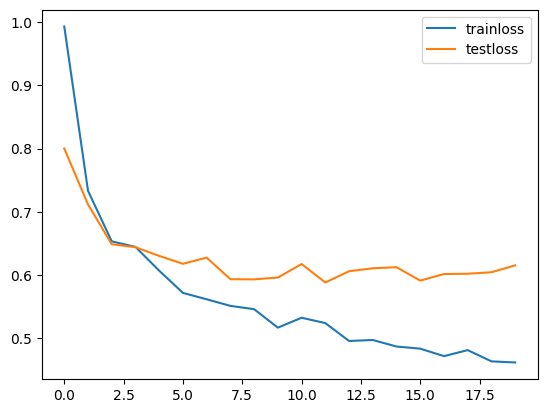

In [ ]:
model_logs.plot() # plot of the model loss during training for 20 epochs

In [ ]:
model_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   epoch          20 non-null     object 
 1   trainloss      20 non-null     float64
 2   testloss       20 non-null     float64
 3   trainaccuracy  20 non-null     object 
 4   testaccuracy   20 non-null     object 
dtypes: float64(2), object(3)
memory usage: 928.0+ bytes


In [ ]:
model_logs['trainaccuracy'] = model_logs['trainaccuracy'].astype(float)
model_logs['testaccuracy'] = model_logs['testaccuracy'].astype(float)

In [ ]:
model_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   epoch          20 non-null     object 
 1   trainloss      20 non-null     float64
 2   testloss       20 non-null     float64
 3   trainaccuracy  20 non-null     float64
 4   testaccuracy   20 non-null     float64
dtypes: float64(4), object(1)
memory usage: 928.0+ bytes


<Axes: >

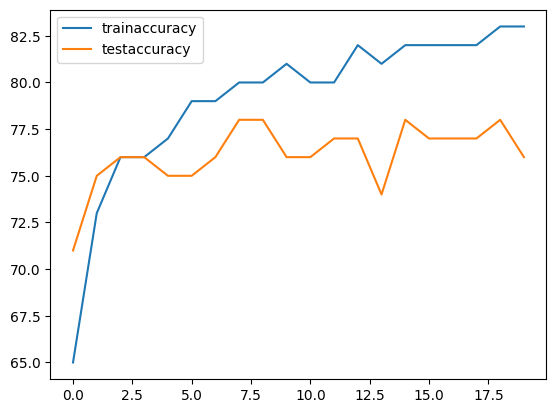

In [ ]:
model_logs.plot(y=['trainaccuracy', 'testaccuracy']) # plot of the model loss during training for 20 epochs

In [ ]:
# Evaluation

y_preds = []

# put the model in eval mode, makes prediction for all images in our test dataset and appends to a list. The list is later concatenated to form a tensor
model.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_logits = model(X)
        y_pred = y_logits.softmax(dim=-1).argmax(dim=-1)
        y_preds.append(y_pred.cpu())
y_preds_tensor = torch.cat(y_preds)
y_preds_tensor

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

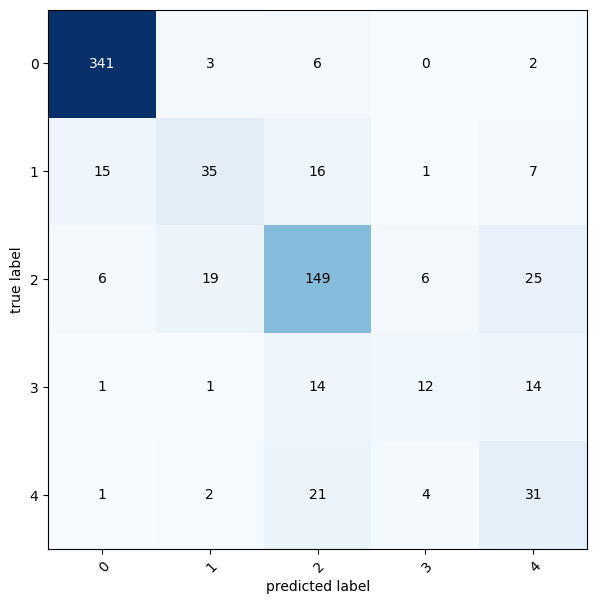

In [ ]:
# Plotting confusion matrix from our predictions and the actual classes

from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(train_data.classes), task='multiclass')
confmat_tensor = confmat(preds=y_preds_tensor, target=test_data.targets)
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), class_names=train_data.classes, figsize=(10, 7))

In [ ]:
# calculating metrics such as the f1score, precision, and recall

f1score = F1Score(task="multiclass", average='micro', num_classes=len(test_data.targets))
f1score = f1score(y_preds_tensor, test_data.targets)
print('F1Score: ',f1score)
precision = Precision(task='multiclass', average='micro', num_classes=len(test_data.targets))
precision = precision(y_preds_tensor, test_data.targets)
print('Precision: ', precision)
recall = Recall(task="multiclass", average='micro', num_classes=len(test_data.targets))
recall = recall(y_preds_tensor, test_data.targets)
print('Recall: ', recall)

F1Score:  tensor(0.7760)
Precision:  tensor(0.7760)
Recall:  tensor(0.7760)


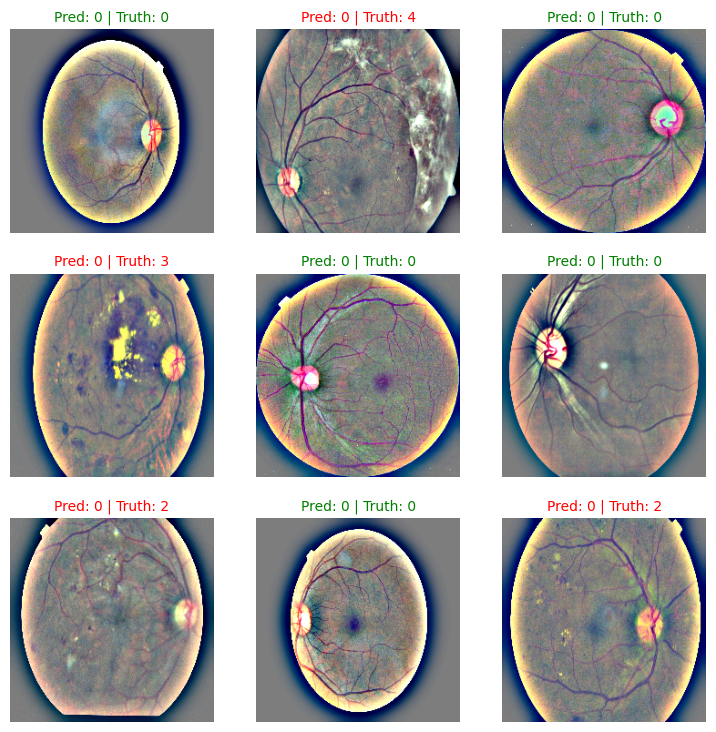

In [ ]:
# Plot predictions
import random
# random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

plt.figure(figsize=(9,9))
ncols = 3
nrows = 3

for i, sample, in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.permute(1,2,0).numpy(), cmap='gray')
    # Prediction labels
    pred_label = test_data.classes[y_preds_tensor[i]]
    # Truth labels
    truth_label = test_data.classes[test_labels[i]]
    # Title for subplot
    title_text = f'Pred: {pred_label} | Truth: {truth_label}'
    # Check for equality between pred and truth and change color of title text
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c='g')
    else:
        plt.title(title_text, fontsize=10, c='r')
    plt.axis(False)

In [ ]:
# Finally, saving the model and the model logs

torch.save(model.state_dict(), '229_colored_gaussian_filter_densenet121.pth')

model_0 = torchvision.models.densenet121()

# ResNet
# cin = model_0.fc.in_features
# model_0.fc = nn.Sequential(
#     nn.Linear(in_features=cin, out_features=len(train_data.classes))
# )

# DenseNet
cin = model_0.classifier.in_features
model_0.classifier = nn.Sequential(
    nn.Linear(in_features=cin, out_features=len(train_data.classes))
)

model_0.load_state_dict(torch.load('229_colored_gaussian_filter_densenet121.pth'))

<ipython-input-43-f0e47412e972>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_0.load_state_dict(torch.load('229_colored_gaussian_filter_densenet121.pth'))


<All keys matched successfully>

In [ ]:
model_logs.to_csv('229_colored_gaussian_filter_densenet121.csv')